# Anomaly Detection

First, I will import the requred packages and read in the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Analysis

Now, let's look at the data we're given

In [2]:
df = pd.read_csv('./Data/nyc_taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


# Data Visualization

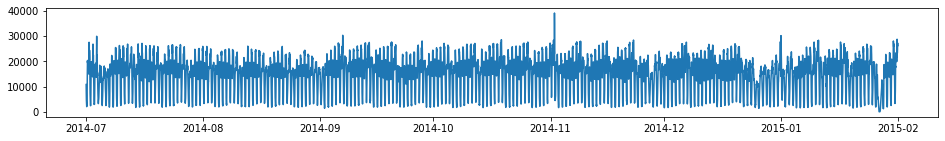

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(16,2))
plt.plot(df)

We can see that this data is very seasonal. This will help us a lot in finding the anomalies because they occur when our data breaks the seasonality trend. Let's zoom in to take a look at a single month.

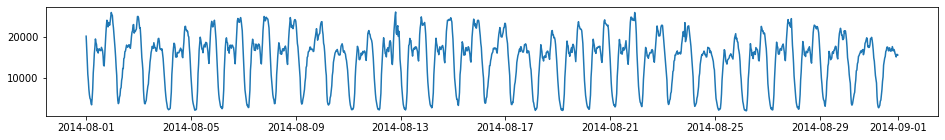

In [4]:
df_single_month = df.loc[df.loc[df.index < "2014-09-01"].index >= "2014-08-01"]
plt.figure(figsize=(16,2))
plt.plot(df_single_month)

We can see each day has a daily low. Let's take a look at what time this occurs at and if the current day of the week affects the timing.

In [5]:
df_low = df_single_month.loc[df_single_month.groupby(pd.Grouper(freq='D')).idxmin().iloc[:, 0]]
df_low['Weekday'] = df_low.index.map(lambda s : s.weekday())
df_low['Time'] = df_low.index - df_low.index.map(lambda s : s.floor(freq ='D'))
df_low['Time'] = df_low.Time.map(lambda s : s.value/60/60/1000000000)
df_low['Day'] = df_low.index.map(lambda s : s.floor(freq ='D'))
df_low.head(14)

,value,Weekday,Time,Day
timestamp,,,,
2014-08-01 05:00:00,3322,4,5.0,2014-08-01
2014-08-02 05:30:00,3611,5,5.5,2014-08-02
2014-08-03 06:00:00,3561,6,6.0,2014-08-03
2014-08-04 03:30:00,2114,0,3.5,2014-08-04
2014-08-05 03:30:00,2011,1,3.5,2014-08-05
2014-08-06 04:30:00,2364,2,4.5,2014-08-06
2014-08-07 04:30:00,2642,3,4.5,2014-08-07
2014-08-08 04:30:00,3601,4,4.5,2014-08-08
2014-08-09 05:30:00,3499,5,5.5,2014-08-09


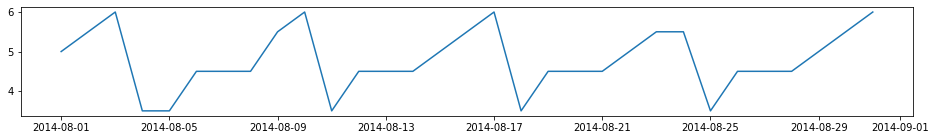

In [6]:
plt.figure(figsize=(16,2))
plt.plot(df_low['Day'], df_low['Time'])

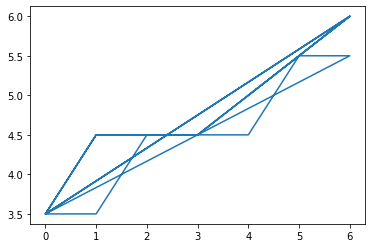

In [7]:
plt.plot(df_low['Weekday'], df_low['Time'])

This shows us that each daily minimum occurs at a pretty consistent time (plus or minus 30 minutes). This can help us to detect anomalies which would be days when this pattern does not hold. This is showing the trend that activity occurs at night.

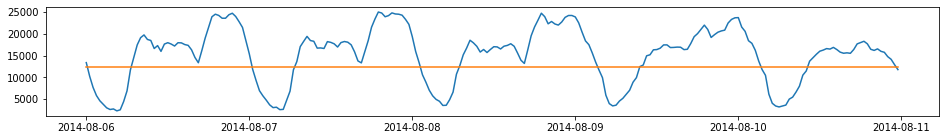

In [8]:
df_two_day = df.loc[df.loc[df.index < "2014-08-11"].index >= "2014-08-06"]
plt.figure(figsize=(16,2))
plt.plot(df_two_day)
plt.plot([df_two_day.index[0], df_two_day.index[-1]],[12500, 12500])

If we measure where the intersection of this line 

In [9]:
df_two_day_ = df_two_day.loc[df_two_day.value < 13000]
df_two_day_.loc[df_two_day_.value >= 11500]

,value
timestamp,
2014-08-06 06:30:00,11761
2014-08-07 00:30:00,11851
2014-08-07 06:30:00,11765
2014-08-08 07:00:00,12731
2014-08-09 03:30:00,11670
2014-08-09 09:30:00,12488
2014-08-09 10:00:00,12845
2014-08-10 03:30:00,11818
2014-08-10 23:00:00,12939


We can see this line intersects the graph at about 7am until about 11pm. This lines up with what we think usual active hours/daylight is. We can use this as an extra feature being times between 8 and 10.

## Feature Engineering

We can use the knowledge we learned in our data visualization to add the following features

In [10]:
df['Weekday'] = df.index.map(lambda s : s.weekday())
df['Time'] = df.index - df.index.map(lambda s : s.floor(freq ='D'))
df['Time'] = df.Time.map(lambda s : s.value/60/60/1000000000)
df['Daylight'] = df.Time.map(lambda s : s <= 21 and s >= 8)
df.head()

,value,Weekday,Time,Daylight
timestamp,,,,
2014-07-01 00:00:00,10844,1,0.0,False
2014-07-01 00:30:00,8127,1,0.5,False
2014-07-01 01:00:00,6210,1,1.0,False
2014-07-01 01:30:00,4656,1,1.5,False
2014-07-01 02:00:00,3820,1,2.0,False


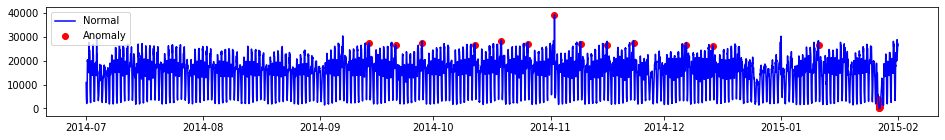

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.002

data = df

min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest

model =  IsolationForest(max_features=3, contamination=outliers_fraction, behaviour="new", random_state=1)
model.fit(data)
# data
df['anomaly2'] = model.predict(data)

# # visualization
fig, ax = plt.subplots(figsize=(16, 2))

a = df.loc[df['anomaly2'] == -1, ['value']] #anomaly

ax.plot(df.index, df['value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')

plt.legend()
plt.show();
# data

Lets take a look at when these occur.

In [12]:
a

,value
timestamp,
2014-09-14 00:00:00,27320
2014-09-21 00:00:00,26477
2014-09-28 00:00:00,27269
2014-10-12 00:00:00,26610
2014-10-19 00:00:00,28093
2014-10-26 00:00:00,26866
2014-11-02 01:00:00,39197
2014-11-09 00:00:00,26931
2014-11-16 00:00:00,26651


# Conclusion
The two largest extreme anomalies that we detected occur on November 2nd 2014 and Janurary 26th 2015. Lets take a look at what happened during this time. We can see that November 2nd 2014 was the NYC Marathon and Janurary 26th 2015 was the day of the "January 2015 North American blizzard". I am happy that my model detected these in addition to other anomalies.